In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess



# Hydro Task Dario Hug #

@Files   :   visualization.ipynb / task01.cpp / task02.cpp

@Time    :   2024/12/17 13:08:54

@Author  :   Dario B. Hug

@Contact :   dariobenjamin.hug@uzh.ch

@Code    :   https://github.com/dariohug/03_Hydro_project.git

Documentation: 

In this Exercise I used c++ and python. The heavy lifting is done in c++ to make the computation as afficient as possible, while python is very handy to plot the computated data.


## General Code ##

In [2]:
def read_csv_data(path):
    data = pd.read_csv(path)
    x = data['x'].values
    times = data.columns[1:]
    return x, times


## Task 1.1 - Advection with first order differencing ##

First order advection equation: $ \frac{\delta f}{\delta t} + v_0 \frac{\delta f}{\delta x} = 0$ 

- Define the domain $ 0 < x < 1 $, with periodic conditions (and ghost cells if necessary). Use $ N = 100 $ points to begin with.
- The advection velocity is v0 = 1. This defines the timestep by the CFL condition as for example $ \Delta t = \frac{\Delta x}{2 v_0} $. Because $ v0 > 0 $, be careful to define the gradient ∂f/∂x in a upstream way using finite difference.
- Perform the time integration with a first order explicit scheme for the spacial derivative. Start with a first order Euler time integration, but feel free to test also higher order schemes (RK2, RK4). Test different initial profiles of f. For example a step function $ f(x,t = 0) = 1 $ if $ x < 0.4 $ for 2 if $ 0.4 < x < 0.6 $, 1 if $ x > 0.6 $, or a gaussian $ f(x,t = 0) = 1 + exp( - \frac{(x-0.5)^2}{\sigma ^2}) $ with $ \sigma = 0.1 $ for instance.
- Explore the evolution over different timescales (number of times it crosses the box), under different resolutions (N = 100, 200, 500,...). Discuss the diffusion, stability and accuracy of the scheme with varying the timestep and the space resolution.

1D Advection Equation: $\frac{\partial f}{\partial t} + v_0 \frac{\partial f}{\partial x} = 0$ 

This equation describes how a value, could for example be a temperature in a medium or a object carried in a steadily moving stream, is carried along one dimension in time. $v_0$ here describes the speed of the advection, in our case we assume the speed to be positive $v_0 > 0$. 

The equation is conservative. To approximate the results we use the firs order euler and the laxWendroff Method. 

### Forward Euler ###

$ f_i^{n+1} = f_i^n - v_0 \frac{\Delta t}{\Delta x} ( f_i^n - f_{i-1}^n) $ 

where:

- $f_i^n$ is the value of $f$ at spatial position $i$ and time step $n$,
- $\Delta t$ is the time step size,
- $\Delta x$ is the spatial step size,
- $f_{i-1}^n$ represents the upwind neighbor.
  
The Forward Euler works surprinsinglz well for its simple design. Diffusion is accuring but for a simple calculations this method is really good. 

### Lax-Wendroff ###

$f_i^{n+1} = f_i^n - \frac{v_0 \Delta t}{2 \Delta x} ( f_{i+1}^n - f_{i-1}^n ) + \frac{(v_0 \Delta t)^2}{2 (\Delta x)^2} ( f_{i+1}^n - 2f_i^n + f_{i-1}^n)$ 

where:

- $f_{i+1}^n$ and $f_{i-1}^n$ are the upwind and downwind neighbors,
- $\Delta t$ is the time step size,
- $\Delta x$ is the spatial step size,
 
The Lax-Wendroff method is more involved as the Forward-Euler and it brings its own challenges. As visible, diffusion is less of a problem, the different timesteps are almost the same. On the other hand it must be monitored more closely on its stability. With the lower resolution this method seems to be quite unstable. 

In [3]:
# C++ file name
cpp_file = "task01_dario_hug.cpp"

# Define output filename
output_file_name = "01_advection_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task01"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

methods = ["firstOrderEuler", "laxWendroff"]
resolutions = ["100", "500"]
data_results = {}

for method in methods: 
    for resolution in resolutions:
        # Check if the compilation succeeded
        if compile_process.returncode == 0:
            print("\033[92m---Compilation succeeded---\033[0m")
            
            # Run the compiled executable
            # This is the beauty of this setup... With a python based solver this computation would take a wile
            # Starting profiles can be "step" or "gaussian"
            # Methods include "firstOrderEuler", "RK2", laxWendroff
            run_command = ["./task01", "10000", output_file_name, resolution, "step", method] # command varys if you use different opperating system!
            run_process = subprocess.run(run_command, capture_output=True, text=True)
        
            # Display the output of the C++ program
            print(f"Output:     {run_process.stdout}")

            data_results[(method, resolution)] = pd.read_csv("01_advection_results.csv")

        else:
            # Display compilation errors
            print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")


---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv



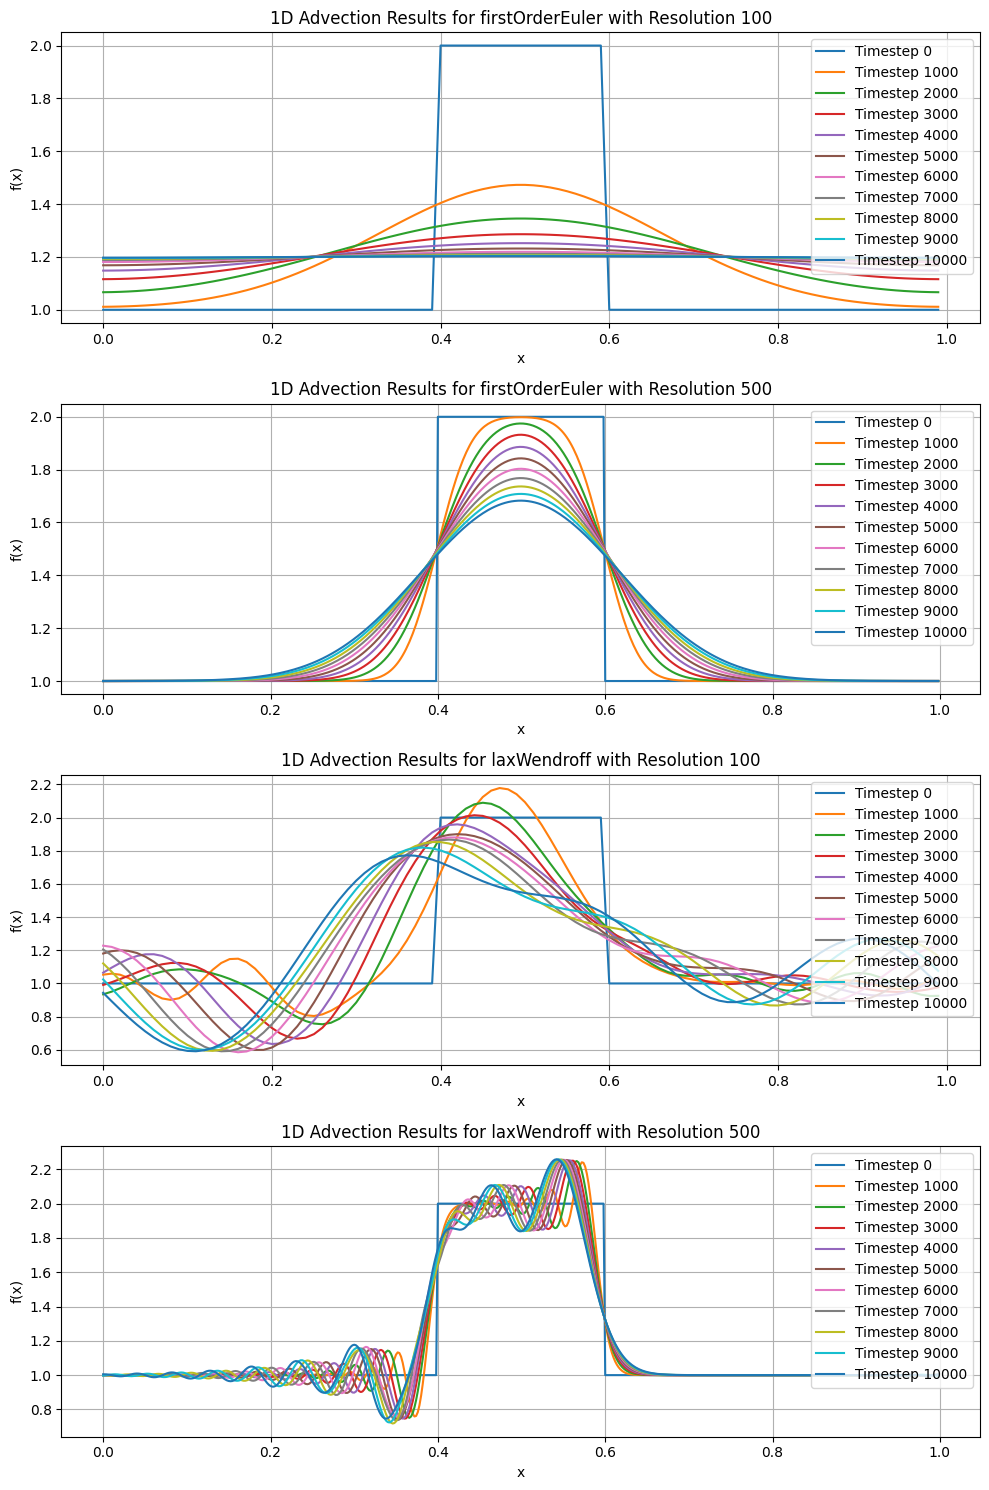

In [4]:
fig, axes = plt.subplots(len(methods) * len(resolutions), 1, figsize=(10, 15))

for ax, ((method, resolution), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Adjust the plotting interval based on the number of timesteps
    num_timesteps = time_series.shape[1]
    plot_interval = max(1, num_timesteps // 10)  # Plot 10 lines

    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f'Timestep {t}')

    ax.set_title(f"1D Advection Results for {method} with Resolution {resolution}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc ="upper right")

plt.tight_layout()
plt.show()

## Task 1.2: Advection with second order finite volume (MUSCL)

Same profiles and set-up as Step 1.
- Use the 2nd order MUSCL scheme: $ f(x,t + \Delta t) = f(x,t) −v0[fR(x + \Delta x/2,t + \Delta t/2) −fR(x − \Delta x/2,t+\Delta t/2)]\Delta t/\Delta x$, where fR is the solution of the Riemann problem at the cell interface. To estimate $ f(x± \Delta x/2,t+ \Delta t/2)$ , reconstruct $ f(x,t)$ on each cell by a linear function. The slope is given by a slope limiter (Minmod, Van Leer). Then move this linear function to the right $ (v0 > 0)$ by a distance $v0 \Delta t/2$. The result provides estimates of the states at $fR(x+ \Delta x/2,t+ \Delta t/2)$ and $fR(x − \Delta x/2,t + \Delta t/2)$.
- At each cell interface one has two estimates of f at $t + \Delta t/2$: one from the cell on the left, one from the cell on the right. The solution of the flux, fR, is the value from the cell upstream ( left if $v0 > 0$ )
- Explore the evolution over different timescales (number of times it crosses the box), under different resolutions (N = 100, 200, 500,...). Discuss the diffusion, stability and accuracy of the scheme with varying the timestep, the space resolution, and the slope limiter. Compare with
the results in Step 1.

### Riemann Solver ###

$ F_{i + \frac{1}{2}} = \frac{1}{2} (F(f_{L, i + 1/2}) + F(f_{R, i + 1/2})) - \frac{\alpha}{2} (f_{R, i + 1/2} - f_{L, i + 1/2}) $ 

where: 

$ \alpha = |v_0| $ and

$ F(f_i) = |v_0| f_i $ 

### Van Leer slope limiter:

$ \phi(r) = \frac{r + |r|}{1 + |r|} $ 

where:

$ r = \frac{f_i - f_{i+1}}{f_{i-1} - f_{i}} $ 

In this task we Advection Problem using the fluxes at the boundry of each cell. These fluxes are calculated using the Riemann solver shown above. In my experience, this way of computation relies on a bigger "gridsize" to remain stable, in my case im calculating and plotting the results for one with 200 cells and one with 500 cells. This way the computation seems to be relatively stable and experiences only small amounts of diffusion. 


In [8]:
# C++ file name
cpp_file = "task01_02_dario_hug.cpp"

# Define output filename
output_file_name = "01_02_advection_second_order_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task01_02"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

resolutions = ["200", "500"]
time_scales = ["5000", "10000", "20000"]
data_results = {}

for time in time_scales:
    for resolution in resolutions:
        # Check if the compilation succeeded
        if run_process.stderr:
            print(f"Error Output: {run_process.stderr}")
        elif compile_process.returncode == 0:
            print("\033[92m---Compilation succeeded---\033[0m")
            
            # Run the compiled executable
            # This is the beauty of this setup... With a python based solver this computation would take a wile

            run_command = ["./task01_02", time, output_file_name, resolution, "gaussian"] # command varys if you use different opperating system!
            run_process = subprocess.run(run_command, capture_output=True, text=True)
        
            # Display the output of the C++ program
            print(f"Output:     {run_process.stdout}")

            data_results[(time, resolution)] = pd.read_csv("01_02_advection_second_order_results.csv")
        else:
            # Display compilation errors
            print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")


---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv

---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv

---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv

---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv

---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv

---Compilation succeeded---
Output:     gaussian
Simulations completed, results saved in: 01_02_advection_second_order_results.csv



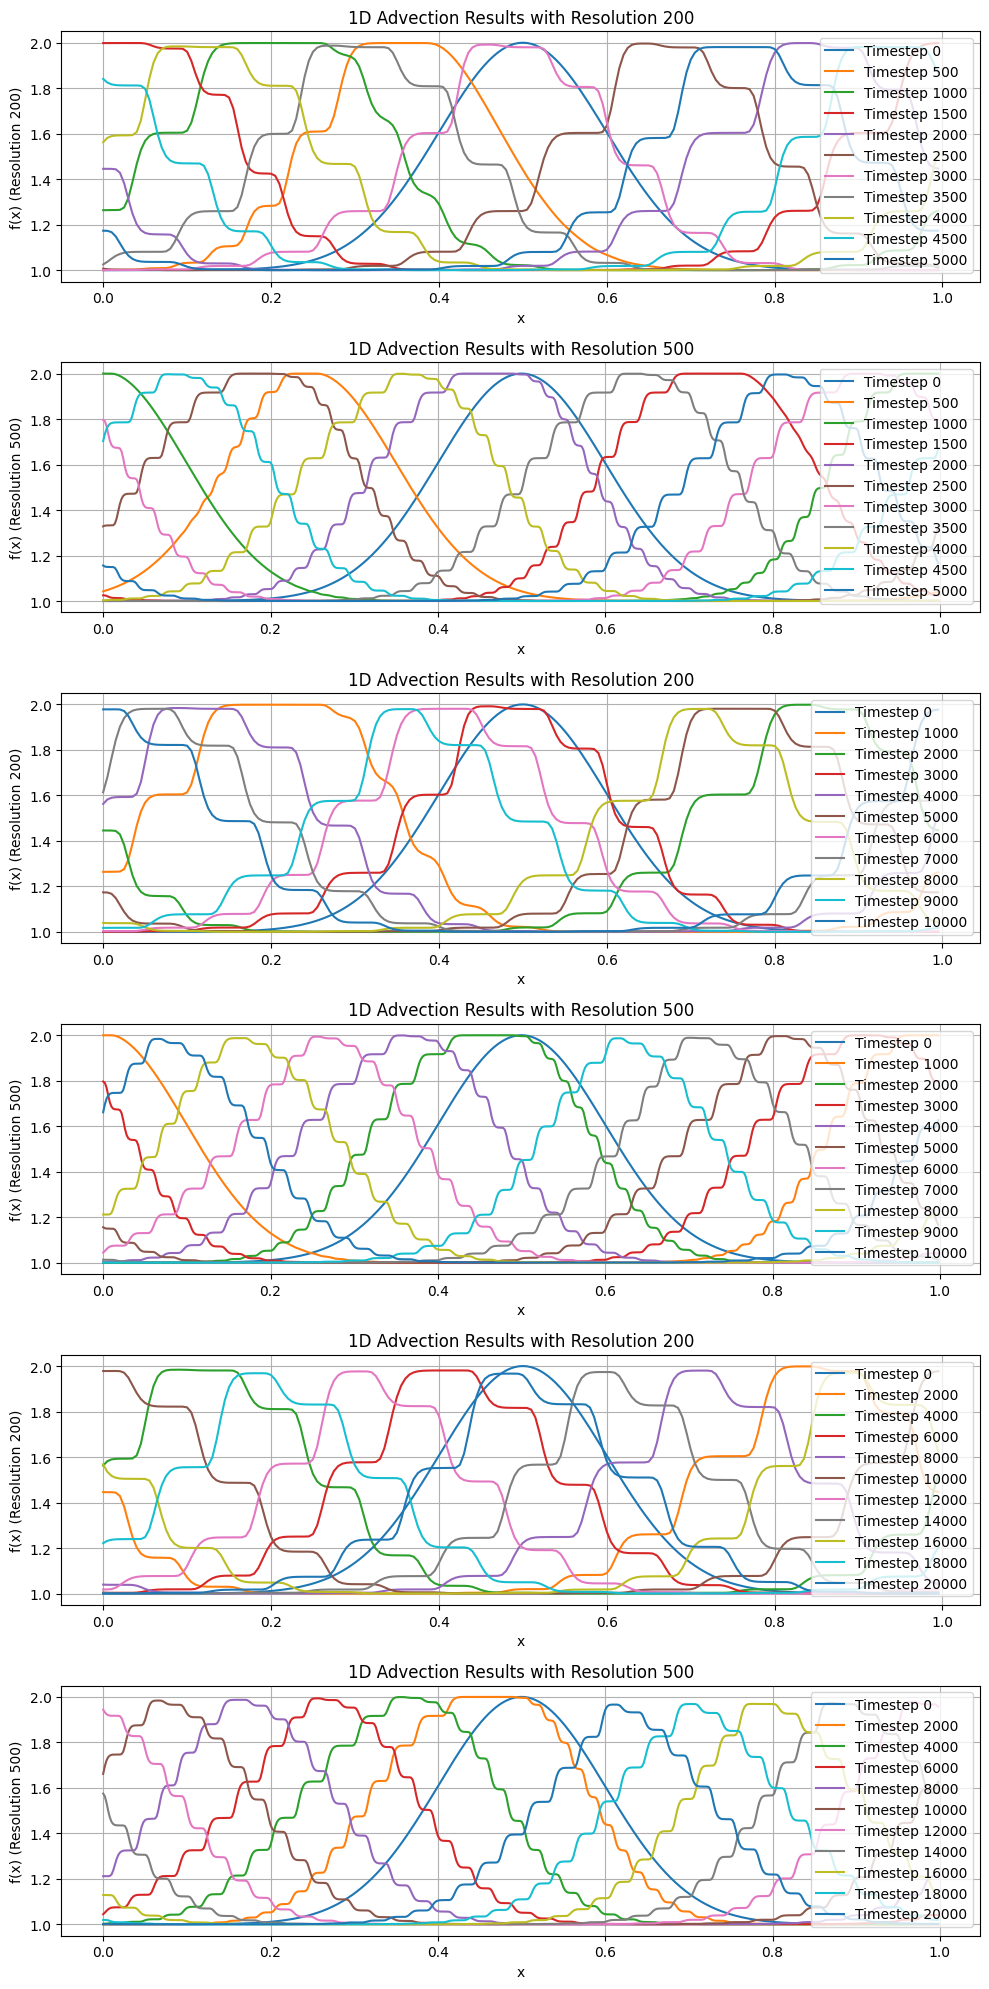

In [9]:
# Example: Assuming 'data_results' contains the necessary data with time series and resolutions
fig, axes = plt.subplots(len(time_scales) * len(resolutions), 1, figsize=(10, 20))

# Ensure axes is iterable in case there's only one subplot
if len(data_results) == 1:
    axes = [axes]

for ax, ((time, resolution), data) in zip(axes, data_results.items()):
    # Extract x values and time series data
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Determine the number of timesteps and adjust the plot interval
    num_timesteps = time_series.shape[1]
    plot_interval = max(1, num_timesteps // 10)

    # Plot results for selected timesteps (now adjusting for timescale)
    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f"Timestep {t}")

    # Customize the plot with resolution-specific title and labels
    ax.set_title(f"1D Advection Results with Resolution {resolution}")
    ax.set_xlabel("x")
    ax.set_ylabel(f"f(x) (Resolution {resolution})")
    ax.grid()
    ax.legend(loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()